In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [2]:
a = np.array([0,1,2])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1


In [3]:
from tensorflow.keras import layers

In [4]:
import pettingzoo
from pettingzoo.mpe import simple_spread_v1

In [8]:
env =simple_spread_v1.parallel_env(max_frames=100)


In [11]:
num_states = env.observation_spaces['agent_0'].shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_spaces['agent_0'].shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_spaces['agent_0'].high[0]
lower_bound = env.action_spaces['agent_0'].low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  18
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [12]:
num_states=21

In [13]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [14]:
std_dev = 0.10
ou_noise = OUActionNoise(mean=np.zeros(num_actions), std_deviation=float(std_dev) * np.ones(num_actions))

In [15]:
class Agent:
    def __init__(self, buffer_capacity=5, batch_size=3):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0
        self.last_states={'agent_0':0,'agent_1':0,'agent_2':0}
        
        self.next_states={'agent_0':0,'agent_1':0,'agent_2':0}
        
        self.state_buffer = np.zeros((self.buffer_capacity, 21))
        self.action_buffer = np.zeros((self.buffer_capacity, 2))
        self.next_state_buffer=np.zeros((self.buffer_capacity,21))
        self.reward_buffer=np.zeros((self.buffer_capacity,1))
        
        self.actor=get_actor()
        self.target_actor=get_actor()
        
        self.critic=get_critic()
        self.target_critic = get_critic()
        
        self.target_critic.set_weights(self.critic.get_weights())
        self.target_actor.set_weights(self.actor.get_weights())
        
        self.critic_lr = 0.003
        self.actor_lr = 0.003
        self.gamma=0.99
        self.tau=0.05
        self.epsilon=1
        self.episode_steps=0
        self.sum_rewards = []
        self.upper_bound=1
        self.lower_bound=-1
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)
    
    
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity   
        for agent in env.agents:
            self.state_buffer[index]=obs_tuple[0][agent]
            self.action_buffer[index]=obs_tuple[1][agent]
            self.reward_buffer[index]=obs_tuple[2][agent]
            self.next_state_buffer[index]=obs_tuple[3][agent]
            self.buffer_counter += 1
            index = self.buffer_counter % self.buffer_capacity        
        
        

    def learn(self):

        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batches=tf.convert_to_tensor(self.state_buffer[batch_indices],dtype=tf.float32)
     
        action_batches=tf.convert_to_tensor(self.action_buffer[batch_indices],dtype=tf.float32)
        next_state_batches=tf.convert_to_tensor(self.next_state_buffer[batch_indices],dtype=tf.float32)
        
        reward_batches=tf.convert_to_tensor(self.reward_buffer[batch_indices],dtype=tf.float32)
        self.update(state_batches,action_batches,next_state_batches,reward_batches)
    
    
    def update(self,state_batch,action_batch,next_state_batch,reward_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
          
            y = reward_batch + self.gamma * self.target_critic([next_state_batch, target_actions], training=True)
           
            critic_value = self.critic([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor(state_batch, training=True)
            critic_value = self.critic([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )

                                    
                                    
    def policy(self,state,noise_object):
        state = tf.convert_to_tensor(state)
        
        sampled_actions = tf.squeeze(self.actor(state))
       
        noise = noise_object()
        sampled_actions = sampled_actions.numpy() + noise
        sampled_actions=np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return sampled_actions
    
    @tf.function
    def update_target(self,target_weights, weights):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))
    

In [16]:
def get_critic():
    state_input=layers.Input(shape=(21))
    state_output=layers.Dense(16,activation='relu')(state_input)
    state_output=layers.Dense(32,activation='relu')(state_output)
    
    action_input=layers.Input(shape=(2))
    action_output=layers.Dense(32,activation='relu')(action_input)

    concat=layers.Concatenate()([state_output,action_output])
    x=layers.Dense(256,activation='relu')(concat)
    
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(128,activation='relu')(x)
    x=layers.Dense(1,activation='linear')(x)
    model=tf.keras.Model([state_input,action_input],x)
    return model

In [17]:
def get_actor():
    last_init=tf.random_uniform_initializer(minval=-0.003,maxval=0.003)
    i=layers.Input(shape=(21))
    x=layers.Dense(256,activation='relu')(i)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(2,activation='tanh')(x)
    model=tf.keras.Model(i,x)
    return model

In [18]:
actor=get_critic()

In [19]:
actor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           352         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
______________________________________________________________________________________________

In [20]:
def change_1(states):

    for i,m in enumerate(states.keys()):
        states[m]=np.array([np.append(states[m],b[i])])
    return states
        
    

In [21]:
agent1=Agent(500000,128)

In [22]:
tf.keras.backend.set_floatx('float32')

In [23]:
ep_reward_list = []

episode_steps=[]

for episode in range(1000):
    states={'agent_0':0,'agent_1':0,'agent_2':0}
    agent1.last_states = env.reset()
    agent1.last_states=change_1(agent1.last_states)
    agent1.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
    agent1.episode_steps=0
    while True:
        
      
        
        actions = {agent: agent1.policy(agent1.last_states[agent],ou_noise) for agent in env.agents}
    
        agent1.next_states,rewards,done,info=env.step(actions)
     
        
        agent1.next_states=change_1(agent1.next_states)
        
     
        
        agent1.sum_rewards={agent: (agent1.sum_rewards[agent]+rewards[agent]) for agent in rewards}
        agent1.episode_steps+=1
        
        agent1.record((agent1.last_states,actions,rewards,agent1.next_states))
        agent1.learn()
   
        
        agent1.update_target(agent1.target_critic.variables,agent1.critic.variables)
        agent1.update_target(agent1.target_actor.variables,agent1.actor.variables)
        if done['agent_0']:
            break
        agent1.last_states=agent1.next_states
    
    print("EPISODE ",episode," STEPS = ",agent1.episode_steps)
    print("REWARD ",agent1.sum_rewards)
        
    ep_reward_list.append(agent1.sum_rewards)
    episode_steps.append(agent1.episode_steps)
        

EPISODE  0  STEPS =  102
REWARD  {'agent_0': -5354.125925157046, 'agent_1': -5353.625925157046, 'agent_2': -5354.125925157046}
EPISODE  1  STEPS =  102
REWARD  {'agent_0': -1132.5388317187476, 'agent_1': -1131.5388317187476, 'agent_2': -1132.5388317187476}
EPISODE  2  STEPS =  102
REWARD  {'agent_0': -969.5019127564358, 'agent_1': -969.0019127564358, 'agent_2': -969.5019127564358}
EPISODE  3  STEPS =  102
REWARD  {'agent_0': -566.5965009809187, 'agent_1': -566.5965009809187, 'agent_2': -566.5965009809187}
EPISODE  4  STEPS =  102
REWARD  {'agent_0': -1307.9777693291253, 'agent_1': -1307.9777693291253, 'agent_2': -1307.9777693291253}
EPISODE  5  STEPS =  102
REWARD  {'agent_0': -795.5171225899741, 'agent_1': -796.0171225899741, 'agent_2': -796.0171225899741}
EPISODE  6  STEPS =  102
REWARD  {'agent_0': -1460.052338734476, 'agent_1': -1460.052338734476, 'agent_2': -1460.052338734476}
EPISODE  7  STEPS =  102
REWARD  {'agent_0': -1298.77482043339, 'agent_1': -1298.77482043339, 'agent_2': 

EPISODE  64  STEPS =  102
REWARD  {'agent_0': -1076.5013710154683, 'agent_1': -1076.5013710154683, 'agent_2': -1076.5013710154683}
EPISODE  65  STEPS =  102
REWARD  {'agent_0': -1254.4155237353598, 'agent_1': -1254.4155237353598, 'agent_2': -1254.4155237353598}
EPISODE  66  STEPS =  102
REWARD  {'agent_0': -1144.75022227289, 'agent_1': -1144.75022227289, 'agent_2': -1144.75022227289}
EPISODE  67  STEPS =  102
REWARD  {'agent_0': -944.4522853777474, 'agent_1': -944.4522853777474, 'agent_2': -944.4522853777474}
EPISODE  68  STEPS =  102
REWARD  {'agent_0': -1032.6694479389078, 'agent_1': -1032.6694479389078, 'agent_2': -1032.6694479389078}
EPISODE  69  STEPS =  102
REWARD  {'agent_0': -939.9628562853859, 'agent_1': -939.9628562853859, 'agent_2': -939.9628562853859}
EPISODE  70  STEPS =  102
REWARD  {'agent_0': -1452.675881700258, 'agent_1': -1452.675881700258, 'agent_2': -1452.675881700258}
EPISODE  71  STEPS =  102
REWARD  {'agent_0': -1021.207880500101, 'agent_1': -1021.207880500101, '

EPISODE  128  STEPS =  102
REWARD  {'agent_0': -1879.2719088301137, 'agent_1': -1879.2719088301137, 'agent_2': -1878.2719088301137}
EPISODE  129  STEPS =  102
REWARD  {'agent_0': -1829.2755006033278, 'agent_1': -1829.2755006033278, 'agent_2': -1829.2755006033278}
EPISODE  130  STEPS =  102
REWARD  {'agent_0': -1462.5097484117623, 'agent_1': -1462.5097484117623, 'agent_2': -1462.5097484117623}
EPISODE  131  STEPS =  102
REWARD  {'agent_0': -1796.3517595100905, 'agent_1': -1796.3517595100905, 'agent_2': -1795.8517595100905}
EPISODE  132  STEPS =  102
REWARD  {'agent_0': -1873.215754979086, 'agent_1': -1873.215754979086, 'agent_2': -1873.215754979086}
EPISODE  133  STEPS =  102
REWARD  {'agent_0': -1876.12876584363, 'agent_1': -1876.12876584363, 'agent_2': -1876.12876584363}
EPISODE  134  STEPS =  102
REWARD  {'agent_0': -1572.011908891708, 'agent_1': -1573.011908891708, 'agent_2': -1573.011908891708}
EPISODE  135  STEPS =  102
REWARD  {'agent_0': -1812.5755423653688, 'agent_1': -1812.575

EPISODE  191  STEPS =  102
REWARD  {'agent_0': -3354.5468393149245, 'agent_1': -3354.5468393149245, 'agent_2': -3354.5468393149245}
EPISODE  192  STEPS =  102
REWARD  {'agent_0': -5200.165423868658, 'agent_1': -5200.165423868658, 'agent_2': -5200.165423868658}
EPISODE  193  STEPS =  102
REWARD  {'agent_0': -5929.790793725107, 'agent_1': -5929.790793725107, 'agent_2': -5929.790793725107}
EPISODE  194  STEPS =  102
REWARD  {'agent_0': -6052.938421842998, 'agent_1': -6052.938421842998, 'agent_2': -6052.938421842998}
EPISODE  195  STEPS =  102
REWARD  {'agent_0': -5912.843307192839, 'agent_1': -5912.843307192839, 'agent_2': -5912.843307192839}
EPISODE  196  STEPS =  102
REWARD  {'agent_0': -6120.138048092391, 'agent_1': -6120.138048092391, 'agent_2': -6120.138048092391}
EPISODE  197  STEPS =  102
REWARD  {'agent_0': -6540.011096325077, 'agent_1': -6540.011096325077, 'agent_2': -6540.011096325077}
EPISODE  198  STEPS =  102
REWARD  {'agent_0': -6115.063096872473, 'agent_1': -6115.0630968724

EPISODE  254  STEPS =  102
REWARD  {'agent_0': -1827.7469044584818, 'agent_1': -1827.7469044584818, 'agent_2': -1827.7469044584818}
EPISODE  255  STEPS =  102
REWARD  {'agent_0': -1890.9578655146609, 'agent_1': -1890.9578655146609, 'agent_2': -1890.9578655146609}
EPISODE  256  STEPS =  102
REWARD  {'agent_0': -2190.7988825323055, 'agent_1': -2190.7988825323055, 'agent_2': -2190.7988825323055}
EPISODE  257  STEPS =  102
REWARD  {'agent_0': -2099.292207517424, 'agent_1': -2098.292207517424, 'agent_2': -2099.292207517424}
EPISODE  258  STEPS =  102
REWARD  {'agent_0': -2005.7991373730833, 'agent_1': -2005.7991373730833, 'agent_2': -2005.7991373730833}
EPISODE  259  STEPS =  102
REWARD  {'agent_0': -3001.3740806418805, 'agent_1': -3001.3740806418805, 'agent_2': -3001.3740806418805}
EPISODE  260  STEPS =  102
REWARD  {'agent_0': -2577.0242265219954, 'agent_1': -2577.0242265219954, 'agent_2': -2577.0242265219954}
EPISODE  261  STEPS =  102
REWARD  {'agent_0': -2287.9276216219787, 'agent_1': 

EPISODE  317  STEPS =  102
REWARD  {'agent_0': -2803.572556277453, 'agent_1': -2803.572556277453, 'agent_2': -2803.572556277453}
EPISODE  318  STEPS =  102
REWARD  {'agent_0': -2775.405322372212, 'agent_1': -2775.405322372212, 'agent_2': -2775.405322372212}
EPISODE  319  STEPS =  102
REWARD  {'agent_0': -6325.424311220831, 'agent_1': -6325.424311220831, 'agent_2': -6325.424311220831}
EPISODE  320  STEPS =  102
REWARD  {'agent_0': -6493.479845376322, 'agent_1': -6493.479845376322, 'agent_2': -6493.479845376322}
EPISODE  321  STEPS =  102
REWARD  {'agent_0': -6745.965705565955, 'agent_1': -6745.965705565955, 'agent_2': -6745.965705565955}
EPISODE  322  STEPS =  102
REWARD  {'agent_0': -6389.298061686146, 'agent_1': -6389.298061686146, 'agent_2': -6389.298061686146}
EPISODE  323  STEPS =  102
REWARD  {'agent_0': -6161.759442731151, 'agent_1': -6161.759442731151, 'agent_2': -6161.759442731151}
EPISODE  324  STEPS =  102
REWARD  {'agent_0': -6228.550114302169, 'agent_1': -6228.550114302169,

EPISODE  381  STEPS =  102
REWARD  {'agent_0': -6012.505035646088, 'agent_1': -6012.505035646088, 'agent_2': -6012.505035646088}
EPISODE  382  STEPS =  102
REWARD  {'agent_0': -5984.187959165111, 'agent_1': -5984.187959165111, 'agent_2': -5984.187959165111}
EPISODE  383  STEPS =  102
REWARD  {'agent_0': -1859.7246710675593, 'agent_1': -1859.7246710675593, 'agent_2': -1859.7246710675593}
EPISODE  384  STEPS =  102
REWARD  {'agent_0': -6009.542172094155, 'agent_1': -6009.542172094155, 'agent_2': -6009.542172094155}
EPISODE  385  STEPS =  102
REWARD  {'agent_0': -6093.389473983245, 'agent_1': -6093.389473983245, 'agent_2': -6093.389473983245}
EPISODE  386  STEPS =  102
REWARD  {'agent_0': -1931.645033008791, 'agent_1': -1931.645033008791, 'agent_2': -1931.645033008791}
EPISODE  387  STEPS =  102
REWARD  {'agent_0': -6094.347066371705, 'agent_1': -6094.347066371705, 'agent_2': -6094.347066371705}
EPISODE  388  STEPS =  102
REWARD  {'agent_0': -6104.303660883822, 'agent_1': -6104.3036608838

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
EPISODE  409  STEPS =  102
REWARD  {'agent_0': -133.40833186384046, 'agent_1': -133.40833186384046, 'agent_2': -133.40833186384046}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]:

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
EPISODE  412  STEPS =  102
REWARD  {'agent_0': -204.52964659516093, 'agent_1': -204.52964659516093, 'agent_2': -204.52964659516093}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]:

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
EPISODE  415  STEPS =  102
REWARD  {'agent_0': -115.313335734411

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
EPISODE  418  STEPS =  102
REWARD  {'agent_0': -188.48030359461708, 'agent_1': -188.48030359461708, 'agent_2': -188.48030359461708}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]:

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

EPISODE  425  STEPS =  102
REWARD  {'agent_0': -122.68516288526612, 'agent_1': -122.68516288526612, 'agent_2': -122.68516288526612}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]:

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
EPISODE  435  STEPS =  102
REWARD  {'agent_0': -99.10550947244298, 'agent_1': -99.10550947244298, 'agent_2': -99.10550947244298}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Re

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
EPISODE  445  STEPS =  102
REWARD  {'agent_0': -125.4072556194723, 'agent_1': -125.4072556194723, 'agent_2': -125.4072556194723}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Re

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
EPISODE  449  STEPS =  102
REWARD  {'agent_0': -195.49276984525156, 'agent_1': -195.49276984525156, 'agent_2': -195.49276984525156}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]:

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

EPISODE  453  STEPS =  102
REWARD  {'agent_0': -147.1380002944721, 'agent_1': -147.1380002944721, 'agent_2': -147.1380002944721}
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Re

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all zeros action
[WARNING]: Received an NaN action. Environment is taking the all

KeyboardInterrupt: 

In [34]:
avg_rewards_0=[]
avg_rewards_1=[]
avg_rewards_2=[]
rewards_0=[]
rewards_1=[]
rewards_2=[]

In [35]:
for m in ep_reward_list:
    for agent in m:
        if agent == 'agent_0':
            rewards_0.append(m[agent])
        
        if agent == 'agent_1':
            rewards_1.append(m[agent])
        
        if agent == 'agent_2':
            rewards_2.append(m[agent])

In [36]:
for i in range(0,467):
    k=np.mean(rewards_0[i:i+100])
    k=np.round(k,3)
    avg_rewards_0.append(k)

In [37]:
for i in range(0,467):
    k=np.mean(rewards_1[i:i+100])
    k=np.round(k,3)
    avg_rewards_1.append(k)

In [38]:
for i in range(0,467):
    k=np.mean(rewards_2[i:i+100])
    k=np.round(k,3)
    avg_rewards_2.append(k)

In [39]:
import matplotlib.pyplot as plt

In [40]:
no_episodes=[]
for i in range(0,467):
    no_episodes.append(i)

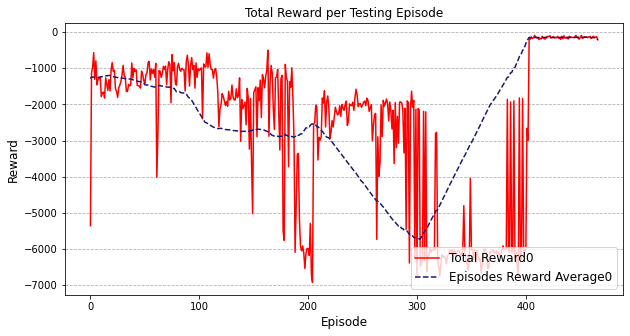

In [41]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [ ]:
np.mean(rewards_0)+np.mean(rewards_1)+np.mean(rewards_2)

In [26]:
np.mean(rewards_0+rewards_1+rewards_2)

-2962.4434868646927

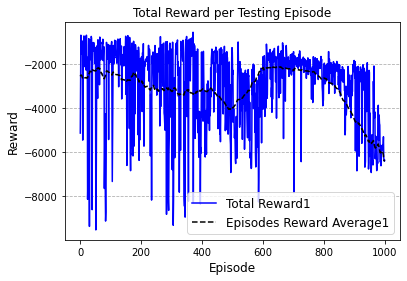

In [27]:
plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()


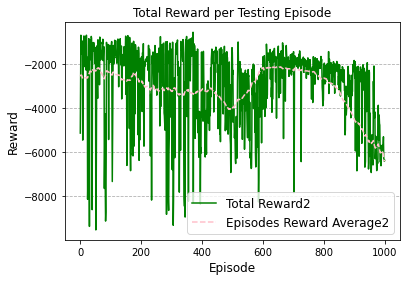

In [28]:
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

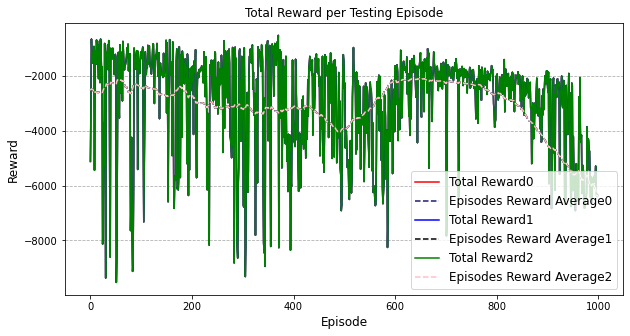

In [29]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')

plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [30]:
total_avg_reward=[]

In [31]:
for i in range(0,1000):
    k=np.mean(rewards_0[i]+rewards_1[i]+rewards_2[i])
    k=np.round(k,3)
    total_avg_reward.append(k)

In [32]:
avg_total=[]

In [33]:
for i in range(0,1000):
    k=np.mean(total_avg_reward[i:i+100])
    k=np.round(k,3)
    avg_total.append(k)

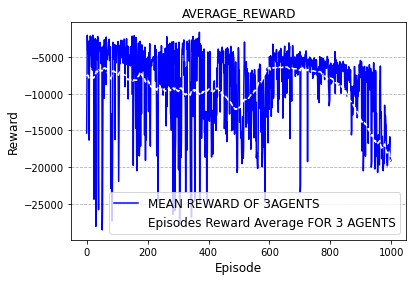

In [34]:
plt.plot(no_episodes,total_avg_reward, color = 'blue',  linestyle = '-', 
        label = 'MEAN REWARD OF 3AGENTS')
plt.plot(no_episodes, avg_total, color = 'white',  linestyle = '--', 
        label = 'Episodes Reward Average FOR 3 AGENTS')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('AVERAGE_REWARD',fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [36]:
agent1.actor.save('actor_model.h5')

In [37]:
agent1.critic.save('critic_model.h5')

[<tf.Variable 'dense_6/kernel:0' shape=(21, 16) dtype=float32, numpy=
 array([[-5.09392142e-01,  3.68164897e-01, -3.83832306e-01,
         -9.02906477e-01, -8.71102452e-01, -9.32410061e-01,
         -6.97699562e-02, -1.79780889e+00, -3.88581567e-02,
          6.25839084e-02, -6.39559189e-03, -7.76263356e-01,
         -6.19652450e-01,  4.70268488e-01, -7.15224743e-01,
         -3.10086697e-01],
        [ 6.82862937e-01, -1.14630064e-04, -1.70903906e-01,
         -1.26941785e-01, -1.27869654e+00, -4.06113058e-01,
          2.57350177e-01, -2.36584079e-02,  1.93885922e-01,
         -1.15936112e+00,  2.42937997e-01, -1.42428017e+00,
         -1.18750162e-01, -1.00830650e+00,  9.20019746e-02,
          7.40710020e-01],
        [ 6.74674332e-01,  3.74028385e-01, -2.35173032e-01,
          1.87499393e-02, -3.99986058e-01, -6.18925869e-01,
         -1.74790487e-01, -8.29222202e-02, -1.48670375e-01,
         -1.78368613e-01,  4.87543404e-01, -5.83423115e-02,
          3.06232721e-01, -2.4169232